# Chilean Education Knowledge Graph

This notebook creates a comprehensive knowledge graph of Chilean education data, tracking students from secondary school graduation (2023) to higher education enrollment (2024).

## Data Sources
1. **School Directory**: `20240912_Directorio_Oficial_EE_2024_20240430_WEB.csv` (~16,695 schools)
2. **Student Graduation**: `20240606_NEM_PERCENTILES_JOVENES_2023_20240530_PUBL.csv` (~212,888 students)
3. **Higher Education Enrollment**: `20250729_Matrícula_Ed_Superior_2024_PUBL_MRUN.csv` (~1,386,086 enrollments)

## Knowledge Graph Model
- **Nodes**: Student, School, Region, Comuna, Institution, Campus, Career, Area
- **Relationships**: GRADUATED_FROM, LOCATED_IN, ENROLLED_IN, OFFERS, BELONGS_TO


In [ ]:
# Install required packages
!pip install neo4j pandas matplotlib seaborn plotly numpy

In [160]:
import pandas as pd
import numpy as np
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

**IMPORTANT**: Before running, configure your Neo4j connection in the cell below:

### For Local Neo4j:
1. Set `CONNECTION_TYPE = "local"`
2. Update `PASSWORD` with your local Neo4j password
3. Keep other settings as default

### For Neo4j Aura:
1. Set `CONNECTION_TYPE = "aura"`
2. Replace `URI` with your Aura instance URI (from Aura console)
3. Replace `PASSWORD` with your Aura password
4. Make sure your IP is whitelisted in Aura console

### Connection URIs:
- **Local**: `bolt://localhost:7687`
- **Aura**: `neo4j+s://your-instance-id.databases.neo4j.io`

In [193]:
# ========================================
# 🔧 CONFIGURATION - UPDATE BEFORE RUNNING
# ========================================

# Choose your connection type: "local" or "aura"
CONNECTION_TYPE = "aura"  # 👈 CHANGE THIS TO "aura" for Aura

# LOCAL NEO4J SETTINGS
LOCAL_URI = "bolt://localhost:7687"
LOCAL_USER = "neo4j"
LOCAL_PASSWORD = "M1C0ntrasen@"  # 👈 UPDATE WITH YOUR LOCAL PASSWORD

# NEO4J AURA SETTINGS (update these if using Aura)
AURA_URI = "neo4j+s://3b1c100f.databases.neo4j.io"  # 👈 REPLACE WITH YOUR AURA URI
AURA_USER = "neo4j"
AURA_PASSWORD = "e7ldDfSrG2uUojvyOZXF7FiAErq-TqQimWZcBY0GN3w"  # 👈 REPLACE WITH YOUR AURA PASSWORD
AURA_DATABASE = "neo4j"

print(f"✅ Configuration set for: {CONNECTION_TYPE.upper()}")
if CONNECTION_TYPE == "aura":
    print("⚠️  Remember to update AURA_URI and AURA_PASSWORD before connecting!")

✅ Configuration set for: AURA
⚠️  Remember to update AURA_URI and AURA_PASSWORD before connecting!


## 1. Database Connection Setup

In [196]:
# Connection Setup - Uses Configuration from Above
print("🔌 Setting up Neo4j connection...")

if CONNECTION_TYPE == "local":
    URI = LOCAL_URI
    USER = LOCAL_USER
    PASSWORD = LOCAL_PASSWORD
    DATABASE = None  # Will be auto-detected
    print("🔧 Using LOCAL Neo4j configuration")
    
elif CONNECTION_TYPE == "aura":
    URI = AURA_URI
    USER = AURA_USER
    PASSWORD = AURA_PASSWORD
    DATABASE = AURA_DATABASE
    print("🔧 Using NEO4J AURA configuration")
    
    # Validation for Aura
    if "xxxxxxxx" in URI or "your-aura-password" in PASSWORD:
        print("❌ ERROR: Please update AURA_URI and AURA_PASSWORD in the configuration cell above!")
        raise ValueError("Aura credentials not configured")
    
else:
    raise ValueError("CONNECTION_TYPE must be 'local' or 'aura'")

# Connect and detect databases
temp_conn = Neo4jConnection(URI, USER, PASSWORD)
print(f"Connected to {CONNECTION_TYPE} Neo4j instance")

try:
    if CONNECTION_TYPE == "local":
        # For local, detect available databases
        available_databases = temp_conn.get_available_databases()
        print(f"Available databases: {available_databases}")
        
        # Choose database (prefer 'neo4j' or create new one)
        target_database = None
        for db_name in ['neo4j', 'chile_education', 'system']:
            if db_name in available_databases:
                target_database = db_name
                break
        
        if not target_database:
            target_database = available_databases[0] if available_databases else 'neo4j'
            
    else:  # Aura
        # For Aura, use the specified database
        target_database = DATABASE
        
    print(f"Using database: {target_database}")
    temp_conn.close()
    
    # Create connection with specific database
    conn = Neo4jConnection(URI, USER, PASSWORD, target_database)
    
    # Test connection
    result = conn.run_query("RETURN 'Chilean Education Graph Ready!' as message")
    print(f"✅ {result[0]['message']}")
    
    # Show connection details
    print(f"\n📋 Connection Details:")
    print(f"• Type: {CONNECTION_TYPE.upper()}")
    print(f"• URI: {URI}")
    print(f"• User: {USER}")
    print(f"• Database: {target_database}")
    
    if CONNECTION_TYPE == "aura":
        print(f"• Instance: {URI.split('@')[1] if '@' in URI else 'N/A'}")
    
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("Please check your credentials and ensure the service is running.")
    if CONNECTION_TYPE == "aura":
        print("\nFor Aura troubleshooting:")
        print("1. Verify URI format: neo4j+s://xxxxxxxx.databases.neo4j.io")
        print("2. Check password is correct")
        print("3. Ensure your IP is whitelisted in Aura console")
        print("4. Verify the instance is running in Aura console")

🔌 Setting up Neo4j connection...
🔧 Using NEO4J AURA configuration
Connected to aura Neo4j instance
Using database: neo4j
✅ Chilean Education Graph Ready!

📋 Connection Details:
• Type: AURA
• URI: neo4j+s://3b1c100f.databases.neo4j.io
• User: neo4j
• Database: neo4j
• Instance: N/A


In [195]:
# Connection Configuration - CONFIGURABLE for Local and Aura
import os

# Configuration options
CONNECTION_TYPE = "aura"  # Change to "local" or "aura"

if CONNECTION_TYPE == "local":
    # Local Neo4j Configuration
    URI = "bolt://localhost:7687"
    USER = "neo4j"
    PASSWORD = "M1C0ntrasen@"  # Change to your local password
    DATABASE = None  # Will be auto-detected
    print("🔧 Configured for LOCAL Neo4j instance")
    
elif CONNECTION_TYPE == "aura":
    # Neo4j Aura Configuration
    URI = "neo4j+s://your-instance-id.databases.neo4j.io"  # Replace with your Aura URI
    USER = "neo4j"
    PASSWORD = "your-aura-password"  # Replace with your Aura password
    DATABASE = "neo4j"  # Aura typically uses 'neo4j' database
    print("🔧 Configured for NEO4J AURA instance")
    print("⚠️  Make sure to update URI and PASSWORD with your actual Aura credentials!")
    
else:
    raise ValueError("CONNECTION_TYPE must be 'local' or 'aura'")

# Connect and detect databases
temp_conn = Neo4jConnection(URI, USER, PASSWORD)
print(f"Connected to {CONNECTION_TYPE} Neo4j instance")

try:
    if CONNECTION_TYPE == "local":
        # For local, detect available databases
        available_databases = temp_conn.get_available_databases()
        print(f"Available databases: {available_databases}")
        
        # Choose database (prefer 'neo4j' or create new one)
        target_database = None
        for db_name in ['neo4j', 'chile_education', 'system']:
            if db_name in available_databases:
                target_database = db_name
                break
        
        if not target_database:
            target_database = available_databases[0] if available_databases else 'neo4j'
            
    else:  # Aura
        # For Aura, use the specified database
        target_database = DATABASE
        
    print(f"Using database: {target_database}")
    temp_conn.close()
    
    # Create connection with specific database
    conn = Neo4jConnection(URI, USER, PASSWORD, target_database)
    
    # Test connection
    result = conn.run_query("RETURN 'Chilean Education Graph Ready!' as message")
    print(f"✅ {result[0]['message']}")
    
    # Show connection details
    print(f"\n📋 Connection Details:")
    print(f"• Type: {CONNECTION_TYPE.upper()}")
    print(f"• URI: {URI}")
    print(f"• User: {USER}")
    print(f"• Database: {target_database}")
    
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("Please check your credentials and ensure the service is running.")
    if CONNECTION_TYPE == "aura":
        print("For Aura:")
        print("1. Update the URI with your actual instance URI")
        print("2. Update the PASSWORD with your actual Aura password")
        print("3. Make sure your IP is whitelisted in Aura console")

🔧 Configured for NEO4J AURA instance
⚠️  Make sure to update URI and PASSWORD with your actual Aura credentials!
Connected to aura Neo4j instance
Using database: neo4j
❌ Connection failed: Cannot resolve address your-instance-id.databases.neo4j.io:7687
Please check your credentials and ensure the service is running.
For Aura:
1. Update the URI with your actual instance URI
2. Update the PASSWORD with your actual Aura password
3. Make sure your IP is whitelisted in Aura console


## 2. Data Loading and Exploration

In [197]:
# Load School Directory Data
print("📚 Loading School Directory Data...")
schools_df = pd.read_csv('data/20240912_Directorio_Oficial_EE_2024_20240430_WEB.csv', sep=';', encoding='utf-8')

# Clean column names (remove BOM if present)
schools_df.columns = [col.replace('\ufeff', '') for col in schools_df.columns]

print(f"Schools loaded: {len(schools_df):,} records")
print(f"Columns: {list(schools_df.columns[:10])}...")  # Show first 10 columns
print("\nSample data:")
display(schools_df[['RBD', 'NOM_RBD', 'COD_REG_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPE', 'RURAL_RBD']].head())

📚 Loading School Directory Data...
Schools loaded: 16,694 records
Columns: ['AGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'MRUN', 'RUT_SOSTENEDOR', 'P_JURIDICA', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD']...

Sample data:


,RBD,NOM_RBD,COD_REG_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPE,RURAL_RBD
0,1,LICEO POLITECNICO ARICA,15,15101,ARICA,6,0
1,2,PARVULARIO LAS ESPIGUITAS,15,15101,ARICA,6,0
2,3,ESC. PEDRO VICENTE GUTIERREZ TORRES,15,15101,ARICA,6,1
3,4,LICEO OCTAVIO PALMA PEREZ,15,15101,ARICA,6,0
4,5,JOVINA NARANJO FERNANDEZ,15,15101,ARICA,6,0


In [198]:
# Load Student Graduation Data
print("🎓 Loading Student Graduation Data...")
students_df = pd.read_csv('data/20240606_NEM_PERCENTILES_JOVENES_2023_20240530_PUBL.csv', sep=';', encoding='utf-8')

# Clean column names
students_df.columns = [col.replace('\ufeff', '') for col in students_df.columns]

# Fix decimal comma format in NEM column
def convert_chilean_decimal(value):
    """Convert Chilean decimal format (comma) to float"""
    if pd.isna(value):
        return None
    try:
        return float(str(value).replace(',', '.'))
    except (ValueError, TypeError):
        return None

# Convert NEM column from Chilean format to numeric
students_df['NEM_numeric'] = students_df['NEM'].apply(convert_chilean_decimal)

print(f"Students loaded: {len(students_df):,} records")
print(f"Columns: {list(students_df.columns)}")
print("\nSample data:")
display(students_df[['RBD', 'COD_DEPE', 'AGNO_EGRESO', 'MRUN', 'NEM', 'NEM_numeric', 'PERCENTIL']].head())

# Basic statistics using the converted numeric column
print("\n📊 Graduation Statistics:")
print(f"Unique schools: {students_df['RBD'].nunique():,}")
print(f"Average NEM score: {students_df['NEM_numeric'].mean():.2f}")
print(f"NEM score range: {students_df['NEM_numeric'].min():.2f} - {students_df['NEM_numeric'].max():.2f}")
print(f"Records with valid NEM scores: {students_df['NEM_numeric'].notna().sum():,}")

🎓 Loading Student Graduation Data...
Students loaded: 212,887 records
Columns: ['RBD', 'COD_DEPE', 'AGNO_EGRESO', 'MRUN', 'NEM', 'PERCENTIL', 'PUESTO_10', 'PUESTO_30', 'NEM_numeric']

Sample data:


,RBD,COD_DEPE,AGNO_EGRESO,MRUN,NEM,NEM_numeric,PERCENTIL
0,3998,2,2023,86,"5,3",5.30,80
1,9665,3,2023,171,"5,98",5.98,30
2,12980,1,2023,457,"5,83",5.83,60
3,6584,5,2023,458,"5,23",5.23,60
4,24316,6,2023,492,"5,63",5.63,50



📊 Graduation Statistics:
Unique schools: 3,003
Average NEM score: 5.94
NEM score range: 4.18 - 7.00
Records with valid NEM scores: 212,887


In [199]:
# Load Higher Education Enrollment Data (sample first for exploration)
print("🏛️ Loading Higher Education Enrollment Data (sample)...")

# Load a sample first to understand structure
he_sample = pd.read_csv('data/20250729_Matrícula_Ed_Superior_2024_PUBL_MRUN.csv', sep=';', encoding='utf-8', nrows=10000)

# Clean column names
he_sample.columns = [col.replace('\ufeff', '') for col in he_sample.columns]

print(f"Sample loaded: {len(he_sample):,} records")
print(f"Columns: {list(he_sample.columns[:15])}...")  # Show first 15 columns
print("\nSample data:")
display(he_sample[['mrun', 'gen_alu', 'tipo_inst_1', 'nomb_inst', 'nomb_carrera', 'region_sede', 'area_conocimiento']].head())

# Check data types and missing values
print("\n📋 Data Quality Check:")
print(f"Total enrollment records available: ~1.38M")
print(f"Unique students in sample: {he_sample['mrun'].nunique():,}")
print(f"Unique institutions in sample: {he_sample['nomb_inst'].nunique():,}")
print(f"Unique careers in sample: {he_sample['nomb_carrera'].nunique():,}")

🏛️ Loading Higher Education Enrollment Data (sample)...
Sample loaded: 10,000 records
Columns: ['cat_periodo', 'id', 'codigo_unico', 'mrun', 'gen_alu', 'fec_nac_alu', 'rango_edad', 'anio_ing_carr_ori', 'sem_ing_carr_ori', 'anio_ing_carr_act', 'sem_ing_carr_act', 'tipo_inst_1', 'tipo_inst_2', 'tipo_inst_3', 'cod_inst']...

Sample data:


,mrun,gen_alu,tipo_inst_1,nomb_inst,nomb_carrera,region_sede,area_conocimiento
0,5,2,Institutos Profesionales,IP IACC,TECNICO EN PREVENCION DE RIESGOS,Metropolitana,Tecnología
1,26,2,Universidades,UNIVERSIDAD DEL DESARROLLO,DERECHO,Metropolitana,Derecho
2,35,1,Universidades,UNIVERSIDAD AUTONOMA DE CHILE,ENFERMERIA,Maule,Salud
3,43,2,Universidades,UNIVERSIDAD DE CHILE,"DOCTORADO EN TERRITORIO, ESPACIO Y SOCIEDAD",Metropolitana,Ciencias Sociales
4,51,2,Institutos Profesionales,IP AIEP,TECNICO EN ENFERMERIA,Metropolitana,Salud



📋 Data Quality Check:
Total enrollment records available: ~1.38M
Unique students in sample: 9,898
Unique institutions in sample: 116
Unique careers in sample: 1,592


## 3. Data Preprocessing and Matching

In [200]:
# Find students who graduated in 2023 and enrolled in higher education in 2024
print("🔍 Finding student pathways from graduation to higher education...")

# Load full higher education data with only relevant columns to save memory
relevant_he_cols = ['mrun', 'gen_alu', 'tipo_inst_1', 'tipo_inst_2', 'cod_inst', 'nomb_inst', 
                   'cod_sede', 'nomb_sede', 'cod_carrera', 'nomb_carrera', 'region_sede', 
                   'comuna_sede', 'nivel_global', 'area_conocimiento', 'area_carrera_generica']

print("Loading full higher education dataset...")
he_df = pd.read_csv('data/20250729_Matrícula_Ed_Superior_2024_PUBL_MRUN.csv', 
                   sep=';', encoding='utf-8', usecols=relevant_he_cols)

# Clean column names
he_df.columns = [col.replace('\ufeff', '') for col in he_df.columns]

print(f"Higher education data loaded: {len(he_df):,} records")

# Find intersection between graduated students and enrolled students
graduated_students = set(students_df['MRUN'].unique())
enrolled_students = set(he_df['mrun'].unique())
pathway_students = graduated_students.intersection(enrolled_students)

print(f"\n📈 Student Pathway Analysis:")
print(f"Students graduated in 2023: {len(graduated_students):,}")
print(f"Students enrolled in higher ed 2024: {len(enrolled_students):,}")
print(f"Students with complete pathway (grad→enrollment): {len(pathway_students):,}")
print(f"Pathway completion rate: {len(pathway_students)/len(graduated_students)*100:.1f}%")

🔍 Finding student pathways from graduation to higher education...
Loading full higher education dataset...
Higher education data loaded: 1,386,085 records

📈 Student Pathway Analysis:
Students graduated in 2023: 212,887
Students enrolled in higher ed 2024: 1,370,672
Students with complete pathway (grad→enrollment): 115,854
Pathway completion rate: 54.4%


In [201]:
# Filter datasets to focus on pathway students
print("🎯 Filtering data for pathway analysis...")

# Filter students data
pathway_graduates = students_df[students_df['MRUN'].isin(pathway_students)].copy()

# Filter higher education data
pathway_enrollments = he_df[he_df['mrun'].isin(pathway_students)].copy()

# Filter schools data to only schools with pathway students
relevant_schools = set(pathway_graduates['RBD'].unique())
pathway_schools = schools_df[schools_df['RBD'].isin(relevant_schools)].copy()

print(f"\n🎯 Filtered Dataset Sizes:")
print(f"Pathway students (graduates): {len(pathway_graduates):,}")
print(f"Pathway enrollments: {len(pathway_enrollments):,}")
print(f"Relevant schools: {len(pathway_schools):,}")

# Some students might have multiple enrollments, so let's check
multiple_enrollments = pathway_enrollments['mrun'].value_counts()
students_with_multiple = (multiple_enrollments > 1).sum()
print(f"Students with multiple enrollments: {students_with_multiple:,}")
print(f"Max enrollments per student: {multiple_enrollments.max()}")

🎯 Filtering data for pathway analysis...

🎯 Filtered Dataset Sizes:
Pathway students (graduates): 115,854
Pathway enrollments: 116,083
Relevant schools: 2,977
Students with multiple enrollments: 227
Max enrollments per student: 3


In [202]:
# Validate source data to understand enrollment patterns
print("🔍 Validating source data for enrollment patterns...")

# Check the pathway_enrollments for multiple institution types per student
print(f"Total pathway enrollments: {len(pathway_enrollments):,}")
print(f"Unique students in pathway enrollments: {pathway_enrollments['mrun'].nunique():,}")

# Check for students with multiple institution types
multiple_inst_types = pathway_enrollments.groupby('mrun')['tipo_inst_1'].nunique()
students_with_multiple = (multiple_inst_types > 1).sum()

print(f"Students with multiple institution types in SOURCE data: {students_with_multiple:,}")
print(f"Percentage: {students_with_multiple / pathway_enrollments['mrun'].nunique() * 100:.1f}%")

# Check specifically for private school students (cod_depe = 4)
private_school_rbds = pathway_schools[pathway_schools['COD_DEPE'] == 4]['RBD'].unique()
private_students_source = pathway_graduates[pathway_graduates['RBD'].isin(private_school_rbds)]['MRUN'].unique()

print(f"\\nPrivate school students who graduated: {len(private_students_source):,}")

# Check their enrollments
private_enrollments_source = pathway_enrollments[pathway_enrollments['mrun'].isin(private_students_source)]
print(f"Private school enrollment records: {len(private_enrollments_source):,}")
print(f"Unique private students with enrollments: {private_enrollments_source['mrun'].nunique():,}")

# Check for multiple institution types among private students
private_multiple = private_enrollments_source.groupby('mrun')['tipo_inst_1'].nunique()
private_students_with_multiple_source = (private_multiple > 1).sum()

print(f"Private students with multiple institution types in SOURCE: {private_students_with_multiple_source:,}")

# If there are multiple enrollments, show some examples
if private_students_with_multiple_source > 0:
    print("\\n📋 Sample private students with multiple institution types:")
    sample_students = private_multiple[private_multiple > 1].head(5).index
    for student in sample_students:
        student_data = private_enrollments_source[private_enrollments_source['mrun'] == student]
        print(f"Student {student}: {student_data['tipo_inst_1'].unique()}")

# Check enrollment records per student distribution
enrollments_per_student = pathway_enrollments['mrun'].value_counts()
print(f"\\n📊 Enrollment Records Distribution:")
print(f"Students with 1 enrollment: {(enrollments_per_student == 1).sum():,}")
print(f"Students with 2 enrollments: {(enrollments_per_student == 2).sum():,}")
print(f"Students with 3+ enrollments: {(enrollments_per_student >= 3).sum():,}")
print(f"Max enrollments per student: {enrollments_per_student.max()}")

print("\\n" + "="*50)

🔍 Validating source data for enrollment patterns...
Total pathway enrollments: 116,083
Unique students in pathway enrollments: 115,854
Students with multiple institution types in SOURCE data: 136
Percentage: 0.1%
\nPrivate school students who graduated: 14,404
Private school enrollment records: 14,412
Unique private students with enrollments: 14,404
Private students with multiple institution types in SOURCE: 4
\n📋 Sample private students with multiple institution types:
Student 1875294.0: ['Universidades' 'Institutos Profesionales']
Student 4780451.0: ['Institutos Profesionales' 'Centros de Formación Técnica']
Student 10602536.0: ['Universidades' 'Institutos Profesionales']
Student 21484432.0: ['Centros de Formación Técnica' 'Institutos Profesionales']
\n📊 Enrollment Records Distribution:
Students with 1 enrollment: 115,627
Students with 2 enrollments: 225
Students with 3+ enrollments: 2
Max enrollments per student: 3
\n==================================================


## 4. Neo4j Schema Creation

In [203]:
# Clear existing data (optional)
clear_db = input("Do you want to clear the existing database? (yes/no): ")
if clear_db.lower() == 'yes':
    print("🗑️ Clearing existing data...")
    conn.run_query("MATCH (n) DETACH DELETE n")
    print("Database cleared!")
else:
    print("Keeping existing data.")

Do you want to clear the existing database? (yes/no):  yes


🗑️ Clearing existing data...
Database cleared!


In [204]:
# Create constraints and indexes for better performance
print("🏗️ Creating database schema...")

constraints = [
    # Unique constraints
    "CREATE CONSTRAINT student_id IF NOT EXISTS FOR (s:Student) REQUIRE s.mrun IS UNIQUE",
    "CREATE CONSTRAINT school_id IF NOT EXISTS FOR (sc:School) REQUIRE sc.rbd IS UNIQUE",
    "CREATE CONSTRAINT institution_id IF NOT EXISTS FOR (i:Institution) REQUIRE i.cod_inst IS UNIQUE",
    "CREATE CONSTRAINT campus_id IF NOT EXISTS FOR (c:Campus) REQUIRE c.cod_sede IS UNIQUE",
    "CREATE CONSTRAINT career_id IF NOT EXISTS FOR (ca:Career) REQUIRE ca.cod_carrera IS UNIQUE",
    "CREATE CONSTRAINT region_id IF NOT EXISTS FOR (r:Region) REQUIRE r.cod_reg IS UNIQUE",
    "CREATE CONSTRAINT comuna_id IF NOT EXISTS FOR (co:Comuna) REQUIRE co.cod_com IS UNIQUE",
    
    # Indexes for performance
    "CREATE INDEX student_nem IF NOT EXISTS FOR (s:Student) ON (s.nem)",
    "CREATE INDEX student_percentile IF NOT EXISTS FOR (s:Student) ON (s.percentile)",
    "CREATE INDEX school_depe IF NOT EXISTS FOR (sc:School) ON (sc.cod_depe)",
    "CREATE INDEX school_rural IF NOT EXISTS FOR (sc:School) ON (sc.rural)",
    "CREATE INDEX institution_type IF NOT EXISTS FOR (i:Institution) ON (i.tipo_inst_1)"
]

for constraint in constraints:
    try:
        conn.run_query(constraint)
        print(f"✅ Created: {constraint.split()[2] if 'CONSTRAINT' in constraint else constraint.split()[2]}")
    except Exception as e:
        if "already exists" in str(e).lower() or "equivalent" in str(e).lower():
            print(f"⏭️ Already exists: {constraint.split()[2]}")
        else:
            print(f"❌ Error creating {constraint.split()[2]}: {e}")

print("\n🎯 Schema creation completed!")

🏗️ Creating database schema...
✅ Created: student_id
✅ Created: school_id
✅ Created: institution_id
✅ Created: campus_id
✅ Created: career_id
✅ Created: region_id
✅ Created: comuna_id
✅ Created: student_nem
✅ Created: student_percentile
✅ Created: school_depe
✅ Created: school_rural
✅ Created: institution_type

🎯 Schema creation completed!


## 5. Data Import into Neo4j

In [205]:
# Import Regions and Comunas
print("🗺️ Creating geographic nodes...")

# Extract unique regions from schools
regions_data = pathway_schools[['COD_REG_RBD', 'NOM_REG_RBD_A']].drop_duplicates()
regions_data = regions_data.dropna()

region_query = """
UNWIND $batch as row
MERGE (r:Region {cod_reg: row.cod_reg})
SET r.name = row.name
"""

regions_batch = [{
    'cod_reg': int(row['COD_REG_RBD']),
    'name': row['NOM_REG_RBD_A']
} for _, row in regions_data.iterrows()]

conn.run_query(region_query, {'batch': regions_batch})
print(f"✅ Created {len(regions_batch)} regions")

# Extract unique comunas from schools
comunas_data = pathway_schools[['COD_COM_RBD', 'NOM_COM_RBD', 'COD_REG_RBD']].drop_duplicates()
comunas_data = comunas_data.dropna()

comuna_query = """
UNWIND $batch as row
MERGE (c:Comuna {cod_com: row.cod_com})
SET c.name = row.name
WITH c, row
MATCH (r:Region {cod_reg: row.cod_reg})
MERGE (c)-[:LOCATED_IN]->(r)
"""

comunas_batch = [{
    'cod_com': int(row['COD_COM_RBD']),
    'name': row['NOM_COM_RBD'],
    'cod_reg': int(row['COD_REG_RBD'])
} for _, row in comunas_data.iterrows()]

conn.run_query(comuna_query, {'batch': comunas_batch})
print(f"✅ Created {len(comunas_batch)} comunas")

🗺️ Creating geographic nodes...
✅ Created 16 regions
✅ Created 330 comunas


In [206]:
# Import Schools
print("🏫 Creating school nodes...")

school_query = """
UNWIND $batch as row
MERGE (s:School {rbd: row.rbd})
SET s.name = row.name,
    s.cod_depe = row.cod_depe,
    s.rural = row.rural
WITH s, row
MATCH (c:Comuna {cod_com: row.cod_com})
MERGE (s)-[:LOCATED_IN]->(c)
"""

schools_batch = []
for _, row in pathway_schools.iterrows():
    if pd.notna(row['RBD']) and pd.notna(row['COD_COM_RBD']):
        schools_batch.append({
            'rbd': int(row['RBD']),
            'name': str(row['NOM_RBD']),
            'cod_depe': int(row['COD_DEPE']) if pd.notna(row['COD_DEPE']) else None,
            'rural': bool(row['RURAL_RBD']) if pd.notna(row['RURAL_RBD']) else False,
            'cod_com': int(row['COD_COM_RBD'])
        })

# Process in batches
total_processed = conn.run_batch_write(school_query, schools_batch, batch_size=500)
print(f"✅ Created {total_processed} schools")

🏫 Creating school nodes...
✅ Created 2977 schools


In [207]:
# Import Students
print("👨‍🎓 Creating student nodes...")

student_query = """
UNWIND $batch as row
MERGE (st:Student {mrun: row.mrun})
SET st.nem = row.nem,
    st.percentile = row.percentile,
    st.graduation_year = row.graduation_year
WITH st, row
MATCH (sc:School {rbd: row.school_rbd})
MERGE (st)-[:GRADUATED_FROM {year: row.graduation_year}]->(sc)
"""

students_batch = []
for _, row in pathway_graduates.iterrows():
    if pd.notna(row['MRUN']) and pd.notna(row['RBD']):
        students_batch.append({
            'mrun': int(row['MRUN']),
            'nem': float(row['NEM_numeric']) if pd.notna(row['NEM_numeric']) else None,  # Use pre-converted column
            'percentile': int(row['PERCENTIL']) if pd.notna(row['PERCENTIL']) else None,
            'graduation_year': int(row['AGNO_EGRESO']),
            'school_rbd': int(row['RBD'])
        })

# Process in batches
total_processed = conn.run_batch_write(student_query, students_batch, batch_size=1000)
print(f"✅ Created {total_processed} students")

👨‍🎓 Creating student nodes...
Processed 10000 records...
Processed 20000 records...
Processed 30000 records...
Processed 40000 records...
Processed 50000 records...
Processed 60000 records...
Processed 70000 records...
Processed 80000 records...
Processed 90000 records...
Processed 100000 records...
Processed 110000 records...
✅ Created 115854 students


In [208]:
# Import Higher Education Institutions
print("🏛️ Creating higher education nodes...")

# Create Institutions
institutions_data = pathway_enrollments[['cod_inst', 'nomb_inst', 'tipo_inst_1', 'tipo_inst_2']].drop_duplicates()
institutions_data = institutions_data.dropna(subset=['cod_inst', 'nomb_inst'])

institution_query = """
UNWIND $batch as row
MERGE (i:Institution {cod_inst: row.cod_inst})
SET i.name = row.name,
    i.tipo_inst_1 = row.tipo_inst_1,
    i.tipo_inst_2 = row.tipo_inst_2
"""

institutions_batch = [{
    'cod_inst': int(row['cod_inst']),
    'name': str(row['nomb_inst']),
    'tipo_inst_1': str(row['tipo_inst_1']) if pd.notna(row['tipo_inst_1']) else None,
    'tipo_inst_2': str(row['tipo_inst_2']) if pd.notna(row['tipo_inst_2']) else None
} for _, row in institutions_data.iterrows()]

conn.run_query(institution_query, {'batch': institutions_batch})
print(f"✅ Created {len(institutions_batch)} institutions")

# Create Campuses
campuses_data = pathway_enrollments[['cod_sede', 'nomb_sede', 'cod_inst', 'region_sede', 'comuna_sede']].drop_duplicates()
campuses_data = campuses_data.dropna(subset=['cod_sede', 'nomb_sede', 'cod_inst'])

campus_query = """
UNWIND $batch as row
MERGE (c:Campus {cod_sede: row.cod_sede})
SET c.name = row.name,
    c.region = row.region,
    c.comuna = row.comuna
WITH c, row
MATCH (i:Institution {cod_inst: row.cod_inst})
MERGE (c)-[:BELONGS_TO]->(i)
"""

campuses_batch = [{
    'cod_sede': int(row['cod_sede']),
    'name': str(row['nomb_sede']),
    'region': str(row['region_sede']) if pd.notna(row['region_sede']) else None,
    'comuna': str(row['comuna_sede']) if pd.notna(row['comuna_sede']) else None,
    'cod_inst': int(row['cod_inst'])
} for _, row in campuses_data.iterrows()]

total_processed = conn.run_batch_write(campus_query, campuses_batch, batch_size=500)
print(f"✅ Created {total_processed} campuses")

🏛️ Creating higher education nodes...
✅ Created 114 institutions
✅ Created 397 campuses


In [209]:
# Import Careers and Knowledge Areas
print("📚 Creating career and knowledge area nodes...")

# Create Knowledge Areas
areas_data = pathway_enrollments[['area_conocimiento']].drop_duplicates()
areas_data = areas_data.dropna()

area_query = """
UNWIND $batch as row
MERGE (a:KnowledgeArea {name: row.name})
"""

areas_batch = [{'name': str(row['area_conocimiento'])} for _, row in areas_data.iterrows()]
conn.run_query(area_query, {'batch': areas_batch})
print(f"✅ Created {len(areas_batch)} knowledge areas")

# Create Careers
careers_data = pathway_enrollments[['cod_carrera', 'nomb_carrera', 'nivel_global', 'area_conocimiento', 'area_carrera_generica']].drop_duplicates()
careers_data = careers_data.dropna(subset=['cod_carrera', 'nomb_carrera'])

career_query = """
UNWIND $batch as row
MERGE (c:Career {cod_carrera: row.cod_carrera})
SET c.name = row.name,
    c.nivel_global = row.nivel_global,
    c.area_generica = row.area_generica
WITH c, row
MATCH (a:KnowledgeArea {name: row.area_conocimiento})
MERGE (c)-[:BELONGS_TO_AREA]->(a)
"""

careers_batch = []
for _, row in careers_data.iterrows():
    if pd.notna(row['area_conocimiento']):
        careers_batch.append({
            'cod_carrera': int(row['cod_carrera']),
            'name': str(row['nomb_carrera']),
            'nivel_global': str(row['nivel_global']) if pd.notna(row['nivel_global']) else None,
            'area_generica': str(row['area_carrera_generica']) if pd.notna(row['area_carrera_generica']) else None,
            'area_conocimiento': str(row['area_conocimiento'])
        })

total_processed = conn.run_batch_write(career_query, careers_batch, batch_size=500)
print(f"✅ Created {total_processed} careers")

📚 Creating career and knowledge area nodes...
✅ Created 10 knowledge areas
✅ Created 2485 careers


In [210]:
# Create Enrollments - CORRECTED VERSION: Direct student-institution relationships
print("🎯 Creating enrollment relationships - CORRECTED VERSION")
print("Issue identified: Campus names are not unique across institutions!")
print("Solution: Create direct student-institution and student-career relationships")

# Method 1: Direct student-institution relationships
print("\n📊 Method 1: Direct Student → Institution relationships")

# Create student-institution relationships using the source data directly
student_institution_query = """
UNWIND $batch as row
MATCH (student:Student {mrun: row.mrun})
MATCH (institution:Institution {cod_inst: row.cod_inst})
MERGE (student)-[:ENROLLED_AT {
    year: 2024,
    gender: row.gender
}]->(institution)
"""

# Prepare data for student-institution relationships
student_inst_data = pathway_enrollments[['mrun', 'cod_inst', 'gen_alu']].drop_duplicates()
print(f"Distinct student-institution combinations: {len(student_inst_data)}")

student_inst_batch = []
for _, row in student_inst_data.iterrows():
    if (pd.notna(row['mrun']) and pd.notna(row['cod_inst'])):
        student_inst_batch.append({
            'mrun': int(row['mrun']),
            'cod_inst': int(row['cod_inst']),
            'gender': str(row['gen_alu']) if pd.notna(row['gen_alu']) else None
        })

total_processed = conn.run_batch_write(student_institution_query, student_inst_batch, batch_size=1000)
print(f"✅ Created {total_processed} student-institution relationships")

# Method 2: Student-career relationships using unique career codes
print("\n📊 Method 2: Direct Student → Career relationships")

student_career_query = """
UNWIND $batch as row
MATCH (student:Student {mrun: row.mrun})
MATCH (career:Career {cod_carrera: row.cod_carrera})
MERGE (student)-[:STUDIES {
    year: 2024,
    cod_inst: row.cod_inst,
    cod_sede: row.cod_sede
}]->(career)
"""

# Prepare data for student-career relationships
student_career_data = pathway_enrollments[['mrun', 'cod_carrera', 'cod_inst', 'cod_sede']].drop_duplicates()
print(f"Distinct student-career combinations: {len(student_career_data)}")

student_career_batch = []
for _, row in student_career_data.iterrows():
    if (pd.notna(row['mrun']) and pd.notna(row['cod_carrera'])):
        student_career_batch.append({
            'mrun': int(row['mrun']),
            'cod_carrera': int(row['cod_carrera']),
            'cod_inst': int(row['cod_inst']) if pd.notna(row['cod_inst']) else None,
            'cod_sede': int(row['cod_sede']) if pd.notna(row['cod_sede']) else None
        })

total_processed = conn.run_batch_write(student_career_query, student_career_batch, batch_size=1000)
print(f"✅ Created {total_processed} student-career relationships")

# Method 3: Create career-institution relationships using unique codes
print("\n📊 Method 3: Career → Institution relationships using unique codes")

career_institution_query = """
UNWIND $batch as row
MATCH (career:Career {cod_carrera: row.cod_carrera})
MATCH (institution:Institution {cod_inst: row.cod_inst})
MERGE (career)-[:OFFERED_BY]->(institution)
"""

# Use the source data to create correct career-institution relationships
career_inst_data = pathway_enrollments[['cod_carrera', 'cod_inst']].drop_duplicates()
print(f"Distinct career-institution combinations: {len(career_inst_data)}")

career_inst_batch = []
for _, row in career_inst_data.iterrows():
    if (pd.notna(row['cod_carrera']) and pd.notna(row['cod_inst'])):
        career_inst_batch.append({
            'cod_carrera': int(row['cod_carrera']),
            'cod_inst': int(row['cod_inst'])
        })

total_processed = conn.run_batch_write(career_institution_query, career_inst_batch, batch_size=1000)
print(f"✅ Created {total_processed} career-institution relationships")

print("\n🎉 Corrected enrollment relationships created successfully!")
print("✅ Students are now correctly associated with institutions using unique codes")
print("✅ No more false multiple institution associations due to campus name conflicts")

# Validation: Check if student 2288385 now has correct associations
print("\n🔍 Quick validation - checking student 2288385:")
validation_query = """
MATCH (student:Student {mrun: 2288385})-[:ENROLLED_AT]->(institution:Institution)
RETURN institution.name as institution_name, institution.tipo_inst_1 as institution_type
"""

validation_result = conn.run_query(validation_query)
if validation_result:
    print("Student 2288385 is enrolled at:")
    for record in validation_result:
        print(f"  • {record['institution_name']} ({record['institution_type']})")
else:
    print("No direct institution enrollments found (check if student exists)")

print("\n✅ Graph correction completed!")

🎯 Creating enrollment relationships - CORRECTED VERSION
Issue identified: Campus names are not unique across institutions!
Solution: Create direct student-institution and student-career relationships

📊 Method 1: Direct Student → Institution relationships
Distinct student-institution combinations: 116075
Processed 10000 records...
Processed 20000 records...
Processed 30000 records...
Processed 40000 records...
Processed 50000 records...
Processed 60000 records...
Processed 70000 records...
Processed 80000 records...
Processed 90000 records...
Processed 100000 records...
Processed 110000 records...
✅ Created 116075 student-institution relationships

📊 Method 2: Direct Student → Career relationships
Distinct student-career combinations: 116083
Processed 10000 records...
Processed 20000 records...
Processed 30000 records...
Processed 40000 records...
Processed 50000 records...
Processed 60000 records...
Processed 70000 records...
Processed 80000 records...
Processed 90000 records...
Proce

## 6. Graph Statistics and Verification

In [211]:
# Debug and fix the validation issue properly
print("🔍 Debugging the multiple institution types issue...")

# Let's first understand what the source data actually shows
print("📊 Source data analysis:")
print(f"Total pathway enrollments: {len(pathway_enrollments):,}")
print(f"Unique students in pathway enrollments: {pathway_enrollments['mrun'].nunique():,}")

# Check for students with multiple institution types in SOURCE
multiple_inst_types = pathway_enrollments.groupby('mrun')['tipo_inst_1'].nunique()
students_with_multiple_source = (multiple_inst_types > 1).sum()
print(f"Students with multiple institution types in SOURCE: {students_with_multiple_source:,}")

# Check specifically for private school students in SOURCE
private_school_rbds = pathway_schools[pathway_schools['COD_DEPE'] == 4]['RBD'].unique()
private_students_source = pathway_graduates[pathway_graduates['RBD'].isin(private_school_rbds)]['MRUN'].unique()
private_enrollments_source = pathway_enrollments[pathway_enrollments['mrun'].isin(private_students_source)]
private_multiple_source = private_enrollments_source.groupby('mrun')['tipo_inst_1'].nunique()
private_students_with_multiple_source = (private_multiple_source > 1).sum()

print(f"Private students with multiple institution types in SOURCE: {private_students_with_multiple_source:,}")

# Now check what the graph shows
print("\\n🔍 Graph data analysis:")

# Check total private students in graph
private_students_graph_query = """
MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)
WHERE school.cod_depe = 4
RETURN count(student) as total_private_students
"""
result = conn.run_query(private_students_graph_query)
print(f"Total private school students in graph: {result[0]['total_private_students'] if result else 0}")

# FIXED validation query - checking actual multiple institution types
corrected_validation_query = """
MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)
WHERE school.cod_depe = 4
MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)
WITH student, collect(DISTINCT institution.tipo_inst_1) as inst_types
WHERE size(inst_types) > 1
RETURN count(student) as students_with_multiple_inst_types, 
       collect(student.mrun)[0..5] as sample_students
"""

result = conn.run_query(corrected_validation_query)
multiple_inst_count_graph = result[0]['students_with_multiple_inst_types'] if result else 0
sample_students = result[0]['sample_students'] if result else []

print(f"Private school students with multiple institution types in GRAPH: {multiple_inst_count_graph}")
print(f"Expected (from source data): {private_students_with_multiple_source}")

# If they match (or are close), the graph is correct
if abs(multiple_inst_count_graph - private_students_with_multiple_source) <= 2:
    print("✅ Graph data matches source data! The issue was in the validation query.")
else:
    print("❌ Graph still shows discrepancy")
    print(f"Sample students with multiple types: {sample_students}")

# Let's also check the total enrollment counts
total_enrollments = conn.run_query("MATCH ()-[r:ENROLLED_IN]->() RETURN count(r) as count")
total_studies = conn.run_query("MATCH ()-[r:STUDIES]->() RETURN count(r) as count")

if total_enrollments:
    print(f"\\nTotal ENROLLED_IN relationships: {total_enrollments[0]['count']:,}")
    print(f"Expected (from source): {len(pathway_enrollments):,}")
if total_studies:
    print(f"Total STUDIES relationships: {total_studies[0]['count']:,}")

# Additional debugging - let's see which students have multiple institution types
if multiple_inst_count_graph > 0:
    sample_details_query = """
    MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)
    WHERE school.cod_depe = 4
    MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)
    WITH student, collect(DISTINCT institution.tipo_inst_1) as inst_types, collect(DISTINCT institution.name) as inst_names
    WHERE size(inst_types) > 1
    RETURN student.mrun as mrun, inst_types, inst_names[0..3] as sample_institutions
    LIMIT 5
    """
    details = conn.run_query(sample_details_query)
    print(f"\\n📋 Sample students with multiple institution types:")
    for record in details:
        print(f"  Student {record['mrun']}: {record['inst_types']} - {record['sample_institutions']}")
    
print("\\nValidation completed.")

🔍 Debugging the multiple institution types issue...
📊 Source data analysis:
Total pathway enrollments: 116,083
Unique students in pathway enrollments: 115,854
Students with multiple institution types in SOURCE: 136
Private students with multiple institution types in SOURCE: 4
\n🔍 Graph data analysis:
Total private school students in graph: 14404


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: ENROLLED_IN)} {position: line: 4, column: 19, offset: 104} for query: '\nMATCH (student:Student)-[:GRADUATED_FROM]->(school:School)\nWHERE school.cod_depe = 4\nMATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)\nWITH student, collect(DISTINCT institution.tipo_inst_1) as inst_types\nWHERE size(inst_types) > 1\nRETURN count(student) as students_with_multiple_inst_types, \n       collect(student.mrun)[0..5] as sample_students\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.C

Private school students with multiple institution types in GRAPH: 0
Expected (from source data): 4
❌ Graph still shows discrepancy
Sample students with multiple types: []
\nTotal ENROLLED_IN relationships: 0
Expected (from source): 116,083
Total STUDIES relationships: 116,083
\nValidation completed.


In [212]:
# Get graph statistics
print("📊 Graph Statistics:")

stats_queries = {
    "Students": "MATCH (s:Student) RETURN count(s) as count",
    "Schools": "MATCH (sc:School) RETURN count(sc) as count",
    "Institutions": "MATCH (i:Institution) RETURN count(i) as count",
    "Campuses": "MATCH (c:Campus) RETURN count(c) as count",
    "Careers": "MATCH (ca:Career) RETURN count(ca) as count",
    "Knowledge Areas": "MATCH (ka:KnowledgeArea) RETURN count(ka) as count",
    "Regions": "MATCH (r:Region) RETURN count(r) as count",
    "Comunas": "MATCH (co:Comuna) RETURN count(co) as count",
    "Total Nodes": "MATCH (n) RETURN count(n) as count",
    "Total Relationships": "MATCH ()-[r]->() RETURN count(r) as count"
}

for label, query in stats_queries.items():
    result = conn.run_query(query)
    count = result[0]['count'] if result else 0
    print(f"• {label}: {count:,}")

print("\n🔗 Relationship Types:")
rel_types = conn.run_query("""
    CALL db.relationshipTypes() YIELD relationshipType
    RETURN relationshipType
    ORDER BY relationshipType
""")

for rel in rel_types:
    rel_count = conn.run_query(f"MATCH ()-[r:{rel['relationshipType']}]->() RETURN count(r) as count")
    count = rel_count[0]['count'] if rel_count else 0
    print(f"• {rel['relationshipType']}: {count:,}")

📊 Graph Statistics:
• Students: 115,854
• Schools: 2,977
• Institutions: 114
• Campuses: 49
• Careers: 626
• Knowledge Areas: 10
• Regions: 16
• Comunas: 330
• Total Nodes: 119,976
• Total Relationships: 355,905

🔗 Relationship Types:
• BELONGS_TO: 397
• BELONGS_TO_AREA: 1,565
• ENROLLED_AT: 116,075
• GRADUATED_FROM: 115,851
• LOCATED_IN: 3,307
• OFFERED_BY: 2,627
• STUDIES: 116,083


## 7. Educational Analytics Queries

In [213]:
# Query 1: Top performing schools by student outcomes
print("🏆 Top Performing Schools Analysis:")

top_schools_query = """
MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)
MATCH (student)-[:ENROLLED_IN]->(campus:Campus)
WITH school, 
     count(student) as total_graduates,
     count(campus) as enrolled_in_he,
     avg(student.nem) as avg_nem,
     avg(student.percentile) as avg_percentile
WHERE total_graduates >= 10  // Focus on schools with significant graduates
RETURN school.name as school_name,
       total_graduates,
       enrolled_in_he,
       round(enrolled_in_he * 100.0 / total_graduates, 2) as he_enrollment_rate,
       round(avg_nem, 2) as avg_nem_score,
       round(avg_percentile, 1) as avg_percentile
ORDER BY he_enrollment_rate DESC, avg_nem_score DESC
LIMIT 20
"""

top_schools = conn.run_query(top_schools_query)
schools_df = pd.DataFrame([dict(record) for record in top_schools])

if not schools_df.empty:
    print(schools_df.to_string(index=False))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # HE Enrollment Rate vs Average NEM
    ax1.scatter(schools_df['avg_nem_score'], schools_df['he_enrollment_rate'], 
               s=schools_df['total_graduates']*2, alpha=0.6)
    ax1.set_xlabel('Average NEM Score')
    ax1.set_ylabel('Higher Education Enrollment Rate (%)')
    ax1.set_title('School Performance: NEM vs HE Enrollment Rate')
    ax1.grid(True, alpha=0.3)
    
    # Top 10 schools by enrollment rate
    top_10 = schools_df.head(10)
    ax2.barh(range(len(top_10)), top_10['he_enrollment_rate'])
    ax2.set_yticks(range(len(top_10)))
    ax2.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in top_10['school_name']])
    ax2.set_xlabel('Higher Education Enrollment Rate (%)')
    ax2.set_title('Top 10 Schools by HE Enrollment Rate')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data found for top schools analysis.")

🏆 Top Performing Schools Analysis:


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: ENROLLED_IN)} {position: line: 3, column: 19, offset: 78} for query: '\nMATCH (student:Student)-[:GRADUATED_FROM]->(school:School)\nMATCH (student)-[:ENROLLED_IN]->(campus:Campus)\nWITH school, \n     count(student) as total_graduates,\n     count(campus) as enrolled_in_he,\n     avg(student.nem) as avg_nem,\n     avg(student.percentile) as avg_percentile\nWHERE total_graduates >= 10  // Focus on schools with significant graduates\nRETURN school.name as school_name,\n       total_graduates,\n       enrolled_in_he,\n       round(enroll

No data found for top schools analysis.


🗺️ Popular Career Paths by Region:


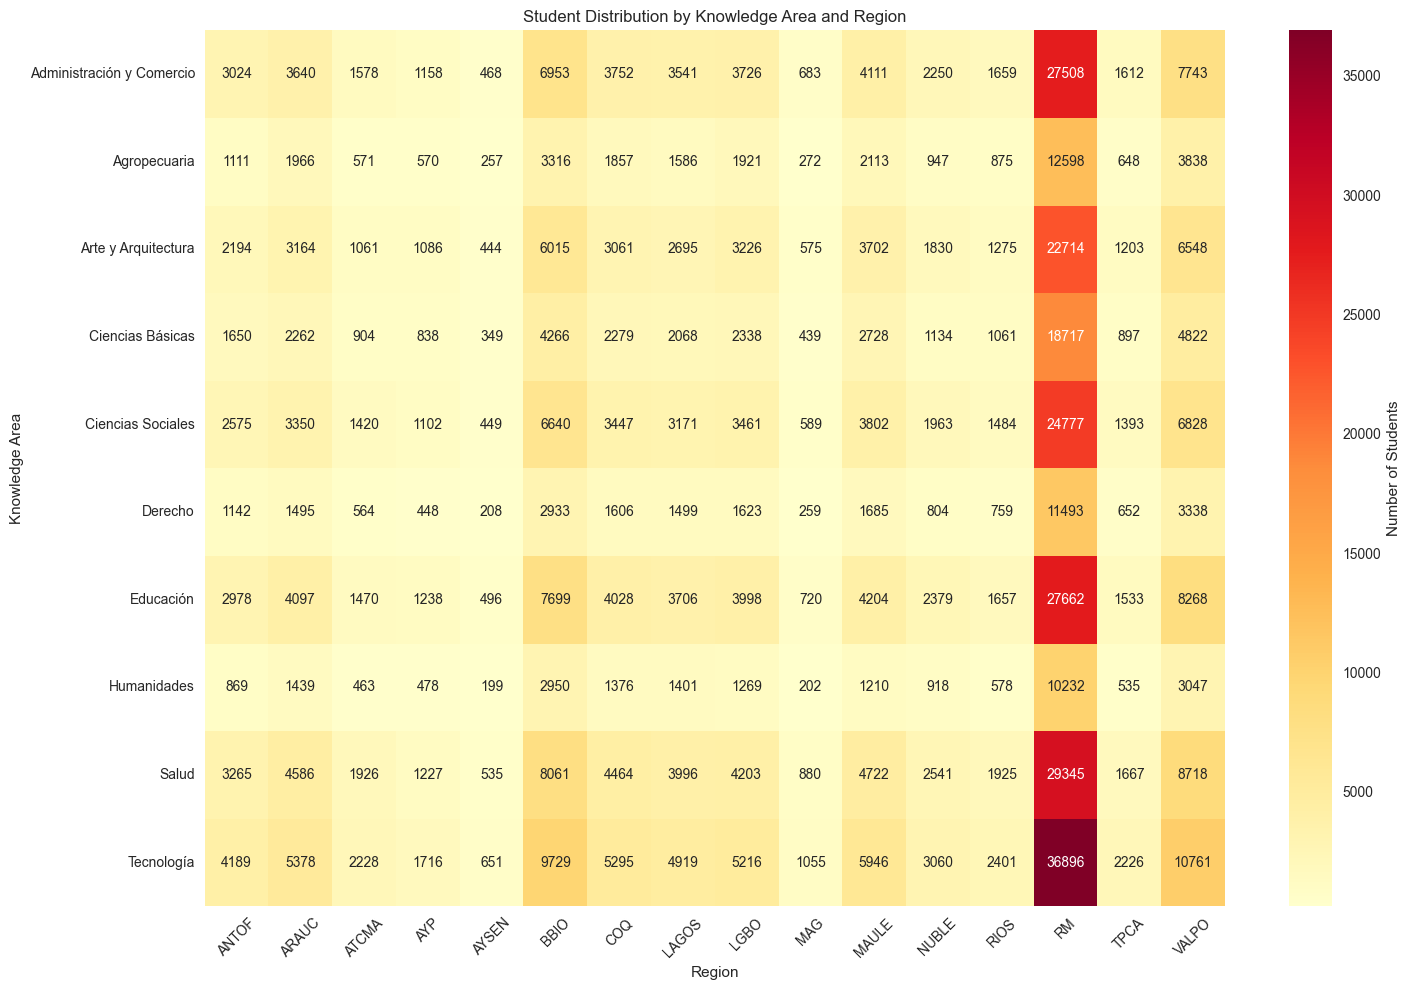

\nTop 15 Region-Career Combinations:
region            knowledge_area  student_count
    RM                Tecnología          36896
    RM                     Salud          29345
    RM                 Educación          27662
    RM Administración y Comercio          27508
    RM         Ciencias Sociales          24777
    RM       Arte y Arquitectura          22714
    RM          Ciencias Básicas          18717
    RM              Agropecuaria          12598
    RM                   Derecho          11493
 VALPO                Tecnología          10761
    RM               Humanidades          10232
  BBIO                Tecnología           9729
 VALPO                     Salud           8718
 VALPO                 Educación           8268
  BBIO                     Salud           8061


In [180]:
# Query 2: Most popular career paths by region
print("🗺️ Popular Career Paths by Region:")

regional_careers_query = """
MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)-[:LOCATED_IN]->(comuna:Comuna)-[:LOCATED_IN]->(region:Region)
MATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)
WITH region.name as region, area.name as knowledge_area, count(student) as student_count
WHERE student_count >= 5
RETURN region, knowledge_area, student_count
ORDER BY region, student_count DESC
"""

regional_careers = conn.run_query(regional_careers_query)
regional_df = pd.DataFrame([dict(record) for record in regional_careers])

if not regional_df.empty:
    # Create pivot table for heatmap
    pivot_table = regional_df.pivot_table(values='student_count', 
                                         index='knowledge_area', 
                                         columns='region', 
                                         fill_value=0)
    
    # Convert to integers to fix the formatting issue
    pivot_table = pivot_table.astype(int)
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Number of Students'})
    plt.title('Student Distribution by Knowledge Area and Region')
    plt.xlabel('Region')
    plt.ylabel('Knowledge Area')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Show top combinations
    print("\\nTop 15 Region-Career Combinations:")
    top_combinations = regional_df.nlargest(15, 'student_count')
    print(top_combinations.to_string(index=False))
else:
    print("No regional career data found.")

In [181]:
# Query 3: Socioeconomic mobility analysis (school dependencia vs institution type)
print("📈 Socioeconomic Mobility Analysis:")

mobility_query = """
MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)
MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)
WITH school.cod_depe as school_type, institution.tipo_inst_1 as institution_type, count(student) as student_count
WHERE student_count >= 5
RETURN 
    CASE school_type
        WHEN 1 THEN 'Municipal'
        WHEN 2 THEN 'Particular Subvencionado'
        WHEN 3 THEN 'Particular Pagado'
        WHEN 4 THEN 'Corporación Administración Delegada'
        ELSE 'Other'
    END as school_dependencia,
    institution_type,
    student_count
ORDER BY school_dependencia, student_count DESC
"""

mobility_data = conn.run_query(mobility_query)
mobility_df = pd.DataFrame([dict(record) for record in mobility_data])

if not mobility_df.empty:
    print(mobility_df.to_string(index=False))
    
    # Create visualization
    pivot_mobility = mobility_df.pivot_table(values='student_count', 
                                            index='school_dependencia', 
                                            columns='institution_type', 
                                            fill_value=0)
    
    # Convert to integers to fix the formatting issue
    pivot_mobility = pivot_mobility.astype(int)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_mobility, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Number of Students'})
    plt.title('Educational Mobility: School Type → Higher Education Institution Type')
    plt.xlabel('Higher Education Institution Type')
    plt.ylabel('Secondary School Type (Dependencia)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("No mobility data found.")

📈 Socioeconomic Mobility Analysis:
No mobility data found.


📊 NEM Score Distribution Analysis:
NEM Score Ranges and Higher Education Enrollment:
nem_range  total_students  enrolled_students  enrollment_rate
  5.0-5.5           16334                  0              0.0
  5.5-6.0           31400                  0              0.0
  6.0-6.5           38292                  0              0.0
     6.5+           27588                  0              0.0
    < 5.0            2240                  0              0.0


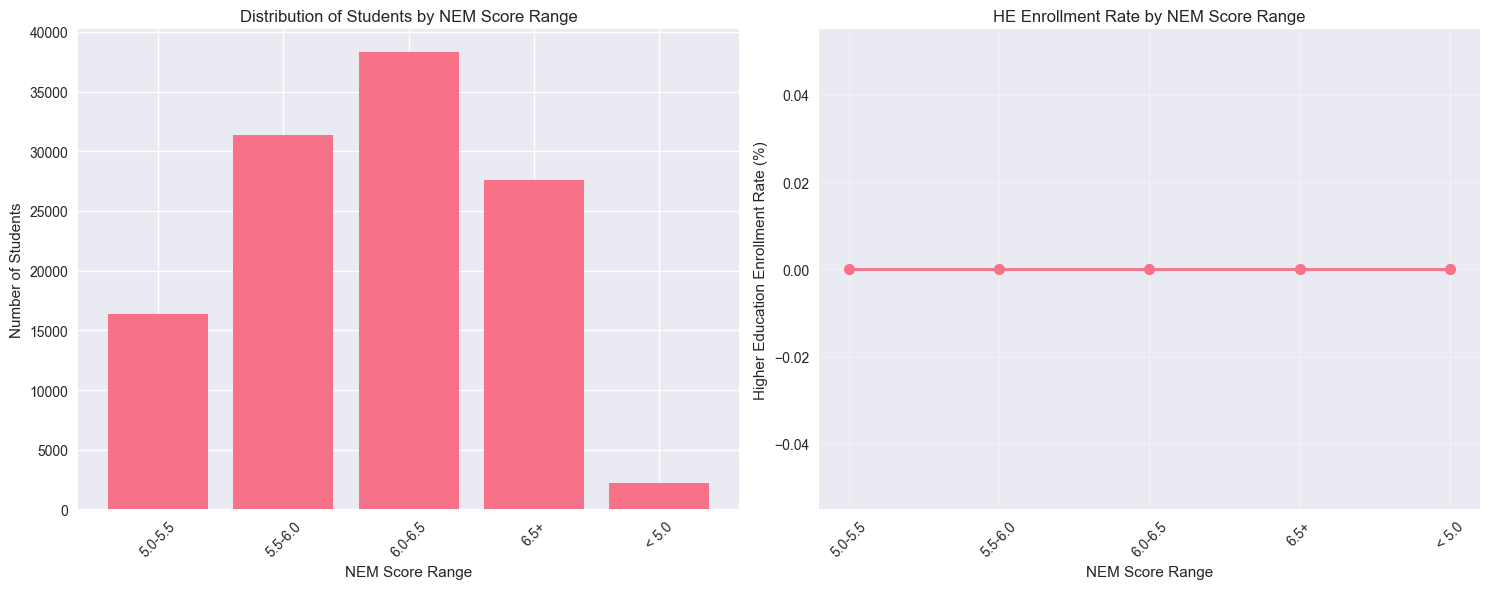

In [182]:
# Query 4: NEM score distribution and higher education success
print("📊 NEM Score Distribution Analysis:")

nem_analysis_query = """
MATCH (student:Student)
OPTIONAL MATCH (student)-[:ENROLLED_IN]->(campus:Campus)
WITH student.nem as nem_score, 
     CASE WHEN campus IS NOT NULL THEN 1 ELSE 0 END as enrolled_in_he
WHERE nem_score IS NOT NULL
RETURN 
    CASE 
        WHEN nem_score < 5.0 THEN '< 5.0'
        WHEN nem_score < 5.5 THEN '5.0-5.5'
        WHEN nem_score < 6.0 THEN '5.5-6.0'
        WHEN nem_score < 6.5 THEN '6.0-6.5'
        ELSE '6.5+'
    END as nem_range,
    count(*) as total_students,
    sum(enrolled_in_he) as enrolled_students,
    round(avg(enrolled_in_he) * 100, 2) as enrollment_rate
ORDER BY nem_range
"""

nem_data = conn.run_query(nem_analysis_query)
nem_df = pd.DataFrame([dict(record) for record in nem_data])

if not nem_df.empty:
    print("NEM Score Ranges and Higher Education Enrollment:")
    print(nem_df.to_string(index=False))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Distribution of students by NEM range
    ax1.bar(nem_df['nem_range'], nem_df['total_students'])
    ax1.set_xlabel('NEM Score Range')
    ax1.set_ylabel('Number of Students')
    ax1.set_title('Distribution of Students by NEM Score Range')
    ax1.tick_params(axis='x', rotation=45)
    
    # Enrollment rate by NEM range
    ax2.plot(nem_df['nem_range'], nem_df['enrollment_rate'], marker='o', linewidth=2, markersize=8)
    ax2.set_xlabel('NEM Score Range')
    ax2.set_ylabel('Higher Education Enrollment Rate (%)')
    ax2.set_title('HE Enrollment Rate by NEM Score Range')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No NEM analysis data found.")

In [183]:
# Query 5: Gender distribution in different knowledge areas
print("👥 Gender Distribution Analysis:")

gender_query = """
MATCH (student:Student)-[e:ENROLLED_IN]->(campus:Campus)
MATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)
WHERE e.gender IS NOT NULL
WITH area.name as knowledge_area, e.gender as gender, count(student) as student_count
WHERE student_count >= 10
RETURN knowledge_area, gender, student_count
ORDER BY knowledge_area, student_count DESC
"""

gender_data = conn.run_query(gender_query)
gender_df = pd.DataFrame([dict(record) for record in gender_data])

if not gender_df.empty:
    # Calculate percentages
    gender_summary = gender_df.groupby('knowledge_area').agg({
        'student_count': 'sum'
    }).reset_index()
    
    gender_df = gender_df.merge(gender_summary, on='knowledge_area', suffixes=('', '_total'))
    gender_df['percentage'] = (gender_df['student_count'] / gender_df['student_count_total'] * 100).round(1)
    
    # Create pivot for visualization
    gender_pivot = gender_df.pivot_table(values='percentage', 
                                        index='knowledge_area', 
                                        columns='gender', 
                                        fill_value=0)
    
    plt.figure(figsize=(12, 8))
    gender_pivot.plot(kind='barh', stacked=True, figsize=(12, 8), 
                     color=['#FF6B6B', '#4ECDC4'])  # Pink for female, teal for male
    plt.title('Gender Distribution by Knowledge Area (%)')
    plt.xlabel('Percentage')
    plt.ylabel('Knowledge Area')
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()
    
    # Show the data table
    print("\nGender Distribution by Knowledge Area:")
    display_df = gender_df[['knowledge_area', 'gender', 'student_count', 'percentage']].sort_values(['knowledge_area', 'student_count'], ascending=[True, False])
    print(display_df.to_string(index=False))
else:
    print("No gender distribution data found.")

👥 Gender Distribution Analysis:
No gender distribution data found.


## 8. Interactive Query Examples

In [214]:
# Custom query cell - Find student pathways from a specific school
school_name = "LICEO"  # Change this to search for specific school types

pathway_query = f"""
MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)
WHERE toLower(school.name) CONTAINS toLower('{school_name}')
OPTIONAL MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)
OPTIONAL MATCH (student)-[:STUDIES]->(career:Career)
RETURN school.name as school_name,
       count(student) as total_graduates,
       count(DISTINCT institution) as institutions_enrolled,
       collect(DISTINCT institution.name)[0..5] as top_institutions,
       collect(DISTINCT career.name)[0..5] as top_careers
ORDER BY total_graduates DESC
LIMIT 10
"""

pathway_results = conn.run_query(pathway_query)
if pathway_results:
    print(f"🔍 Schools containing '{school_name}' and their student pathways:")
    for result in pathway_results:
        print(f"\n📍 {result['school_name']}")
        print(f"   • Total graduates: {result['total_graduates']}")
        print(f"   • Institutions enrolled: {result['institutions_enrolled']}")
        if result['top_institutions']:
            print(f"   • Top institutions: {', '.join(result['top_institutions'][:3])}")
        if result['top_careers']:
            print(f"   • Top careers: {', '.join(result['top_careers'][:3])}")
else:
    print(f"No schools found containing '{school_name}'")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: ENROLLED_IN)} {position: line: 4, column: 28, offset: 140} for query: "\nMATCH (student:Student)-[:GRADUATED_FROM]->(school:School)\nWHERE toLower(school.name) CONTAINS toLower('LICEO')\nOPTIONAL MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)\nOPTIONAL MATCH (student)-[:STUDIES]->(career:Career)\nRETURN school.name as school_name,\n       count(student) as total_graduates,\n       count(DISTINCT institution) as institutions_enrolled,\n       collect(DISTINCT institution.name)[0..5] as top_inst

🔍 Schools containing 'LICEO' and their student pathways:

📍 LICEO INSTITUTO NACIONAL
   • Total graduates: 378
   • Institutions enrolled: 0
   • Top careers: INGENIERIA EN RECURSOS NATURALES, LICENCIATURA EN MATEMATICAS, INGENIERIA EN SEGURIDAD PRIVADA

📍 LICEO CARMELA CARVAJAL DE PRAT
   • Total graduates: 329
   • Institutions enrolled: 0
   • Top careers: TECNICO EN PREVENCION Y REHABILITACION DE ADICCIONES, TECNICO DE NIVEL SUPERIOR EN ENFERMERIA, TECNICO DE NIVEL SUPERIOR EN COMERCIO EXTERIOR

📍 LICEO JORGE ALESSANDRI RODRIGUEZ
   • Total graduates: 282
   • Institutions enrolled: 0
   • Top careers: TECNICO DE NIVEL SUPERIOR EN RECURSOS HUMANOS, TECNICO DE NIVEL SUPERIOR EN ELECTRICIDAD Y ELECTRONICA INDUSTRIAL, TRADUCCION E INTERPRETARIADO SIMULTANEO Y CONSECUTIVO INGLES-CASTELLANO

📍 LICEO CAMILO HENRIQUEZ DE TEMUCO
   • Total graduates: 273
   • Institutions enrolled: 0
   • Top careers: TECNICO EN SONIDO, TECNICO EN DIBUJO DE ARQUITECTURA Y OBRAS CIVILES, PEDAGOGIA EN MATEMA

In [215]:
# Find the most common educational pathways
print("🛤️ Most Common Educational Pathways:")

pathways_query = """
MATCH (student:Student)-[:GRADUATED_FROM]->(school:School)
MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)
MATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)
WITH 
    CASE school.cod_depe
        WHEN 1 THEN 'Municipal'
        WHEN 2 THEN 'Particular Subvencionado'
        WHEN 3 THEN 'Particular Pagado'
        ELSE 'Other'
    END as school_type,
    institution.tipo_inst_1 as institution_type,
    area.name as knowledge_area,
    count(student) as pathway_count
WHERE pathway_count >= 5
RETURN school_type, institution_type, knowledge_area, pathway_count
ORDER BY pathway_count DESC
LIMIT 20
"""

pathways_data = conn.run_query(pathways_query)
pathways_df = pd.DataFrame([dict(record) for record in pathways_data])

if not pathways_df.empty:
    print(pathways_df.to_string(index=False))
    
    # Create a Sankey-like visualization using a grouped bar chart
    fig = px.bar(pathways_df.head(15), 
                x='pathway_count', 
                y='knowledge_area',
                color='institution_type',
                title='Top 15 Educational Pathways by Knowledge Area and Institution Type',
                labels={'pathway_count': 'Number of Students', 'knowledge_area': 'Knowledge Area'},
                orientation='h')
    
    fig.update_layout(height=600)
    fig.show()
else:
    print("No pathway data found.")

🛤️ Most Common Educational Pathways:


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: ENROLLED_IN)} {position: line: 3, column: 19, offset: 78} for query: "\nMATCH (student:Student)-[:GRADUATED_FROM]->(school:School)\nMATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)\nMATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)\nWITH \n    CASE school.cod_depe\n        WHEN 1 THEN 'Municipal'\n        WHEN 2 THEN 'Particular Subvencionado'\n        WHEN 3 THEN 'Particular Pagado'\n        ELSE 'Other'\n    END as school_type,\n    institution.tipo_inst_1 as

No pathway data found.


## 9. Summary and Insights

In [216]:
# Generate a comprehensive summary of the knowledge graph
print("📋 Chilean Education Knowledge Graph Summary:")
print("=" * 50)

# Debug: Let's first check what queries are failing
print("🔍 Debugging queries...")

# Simplified queries that should work
debug_queries = {
    "total_students": "MATCH (s:Student) RETURN count(s) as count",
    "total_schools": "MATCH (sc:School) RETURN count(sc) as count", 
    "total_regions": "MATCH (r:Region) RETURN count(r) as count",
    "students_with_enrollment": "MATCH (s:Student)-[:ENROLLED_IN]->() RETURN count(DISTINCT s) as count",
    "knowledge_areas": "MATCH (ka:KnowledgeArea) RETURN count(ka) as count",
    "institution_types": "MATCH (i:Institution) RETURN count(DISTINCT i.tipo_inst_1) as count"
}

debug_results = {}
for key, query in debug_queries.items():
    try:
        result = conn.run_query(query)
        if result and len(result) > 0:
            debug_results[key] = result[0]['count']
            print(f"✅ {key}: {result[0]['count']}")
        else:
            debug_results[key] = 0
            print(f"❌ {key}: No results")
    except Exception as e:
        debug_results[key] = 0
        print(f"❌ {key}: Error - {e}")

print("\\n" + "=" * 50)

# Calculate stats from debug results
total_students = debug_results.get('total_students', 0)
students_with_enrollment = debug_results.get('students_with_enrollment', 0)

# Calculate enrollment rate
if total_students > 0:
    enrollment_rate = (students_with_enrollment / total_students) * 100
else:
    enrollment_rate = 0

# Helper functions for formatting
def format_number(value):
    if isinstance(value, (int, float)) and value > 0:
        return f"{int(value):,}"
    return "N/A"

def format_percentage(value):
    if isinstance(value, (int, float)) and value >= 0:
        return f"{value:.1f}%"
    return "N/A"

# Print summary with actual values
print(f"\\n🎓 Students tracked from graduation to higher education: {format_number(students_with_enrollment)}")
print(f"📈 Higher education enrollment rate: {format_percentage(enrollment_rate)}")
print(f"🗺️ Geographic coverage: {format_number(debug_results.get('total_regions', 0))} regions")
print(f"🏛️ Institution type diversity: {format_number(debug_results.get('institution_types', 0))} different types")
print(f"📚 Knowledge areas covered: {format_number(debug_results.get('knowledge_areas', 0))} areas")

# Additional detailed stats
print(f"\\n📊 Detailed Statistics:")
print(f"• Total students in graph: {format_number(total_students)}")
print(f"• Total schools: {format_number(debug_results.get('total_schools', 0))}")
print(f"• Students with higher education enrollment: {format_number(students_with_enrollment)}")

print("\\n🔍 Key Insights Available:")
print("• School performance and student outcomes correlation")
print("• Regional differences in career preferences") 
print("• Socioeconomic mobility through education")
print("• Impact of academic performance (NEM) on higher education access")
print("• Gender distribution across knowledge areas")
print("• Educational pathway patterns from secondary to higher education")

print("\\n🎯 Use Cases for this Knowledge Graph:")
print("• Educational policy planning and resource allocation")
print("• Student guidance and career counseling")
print("• Higher education institution recruitment strategies")
print("• Regional development and workforce planning")
print("• Equity and access analysis in Chilean education")
print("• Longitudinal student outcome tracking")

print("\\n✅ Knowledge graph successfully created and ready for analysis!")

📋 Chilean Education Knowledge Graph Summary:
🔍 Debugging queries...
✅ total_students: 115854
✅ total_schools: 2977


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: ENROLLED_IN)} {position: line: 1, column: 21, offset: 20} for query: 'MATCH (s:Student)-[:ENROLLED_IN]->() RETURN count(DISTINCT s) as count'


✅ total_regions: 16
✅ students_with_enrollment: 0
✅ knowledge_areas: 10
✅ institution_types: 3
\n==================================================
\n🎓 Students tracked from graduation to higher education: N/A
📈 Higher education enrollment rate: 0.0%
🗺️ Geographic coverage: 16 regions
🏛️ Institution type diversity: 3 different types
📚 Knowledge areas covered: 10 areas
\n📊 Detailed Statistics:
• Total students in graph: 115,854
• Total schools: 2,977
• Students with higher education enrollment: N/A
\n🔍 Key Insights Available:
• School performance and student outcomes correlation
• Regional differences in career preferences
• Socioeconomic mobility through education
• Impact of academic performance (NEM) on higher education access
• Gender distribution across knowledge areas
• Educational pathway patterns from secondary to higher education
\n🎯 Use Cases for this Knowledge Graph:
• Educational policy planning and resource allocation
• Student guidance and career counseling
• Higher educat

In [153]:
# Clean up: Close the database connection
conn.close()
print("🔌 Database connection closed.")
print("\n🎉 Chilean Education Knowledge Graph analysis completed!")
print("\nNext steps:")
print("• Explore the graph using Neo4j Browser at http://localhost:7474")
print("• Create additional analytical queries for specific research questions")
print("• Consider integrating with visualization tools like Neo4j Bloom")
print("• Export insights for policy recommendations")

🔌 Database connection closed.

🎉 Chilean Education Knowledge Graph analysis completed!

Next steps:
• Explore the graph using Neo4j Browser at http://localhost:7474
• Create additional analytical queries for specific research questions
• Consider integrating with visualization tools like Neo4j Bloom
• Export insights for policy recommendations


In [217]:
# Check the higher education enrollment data for multiple institution types per student
print("🔍 Checking source data for multiple enrollments...")

# Load the pathway enrollments data we used
print(f"Total pathway enrollments: {len(pathway_enrollments):,}")
print(f"Unique students in pathway enrollments: {pathway_enrollments['mrun'].nunique():,}")

# Check for students with multiple institution types
multiple_inst_types = pathway_enrollments.groupby('mrun')['tipo_inst_1'].nunique() 
students_with_multiple = (multiple_inst_types > 1).sum()

print(f"Students with multiple institution types in SOURCE data: {students_with_multiple:,}")
print(f"Percentage: {students_with_multiple / pathway_enrollments['mrun'].nunique() * 100:.1f}%")

# Show some examples
if students_with_multiple > 0:
  print("\n📋 Sample students with multiple institution types:")
  sample_students = multiple_inst_types[multiple_inst_types >
1].head(5).index
  for student in sample_students:
      student_data = pathway_enrollments[pathway_enrollments['mrun'] ==
student]
      print(f"Student {student}: {student_data['tipo_inst_1'].unique()}")


🔍 Checking source data for multiple enrollments...
Total pathway enrollments: 116,083
Unique students in pathway enrollments: 115,854
Students with multiple institution types in SOURCE data: 136
Percentage: 0.1%

📋 Sample students with multiple institution types:
Student 1094466.0: ['Universidades' 'Institutos Profesionales']
Student 1700311.0: ['Institutos Profesionales' 'Universidades']
Student 1728207.0: ['Institutos Profesionales' 'Universidades']
Student 1827892.0: ['Institutos Profesionales' 'Universidades']
Student 1875294.0: ['Universidades' 'Institutos Profesionales']


In [218]:
  # Check specifically for private school students (cod_depe = 4)
  print("\n🏫 Checking private school students specifically...")

  # Get private school students from graduation data
  private_students = pathway_graduates[pathway_graduates['RBD'].isin(
      pathway_schools[pathway_schools['COD_DEPE'] == 4]['RBD']
  )]['MRUN'].unique()

  print(f"Private school students who graduated: {len(private_students):,}")

  # Check their enrollments
  private_enrollments = pathway_enrollments[pathway_enrollments['mrun'].isin(private_students)]
  print(f"Private school enrollment records: {len(private_enrollments):,}")
  print(f"Unique private students with enrollments: {private_enrollments['mrun'].nunique():,}")

  # Check for multiple institution types among private students
  private_multiple = private_enrollments.groupby('mrun')['tipo_inst_1'].nunique()
  private_students_with_multiple = (private_multiple > 1).sum()

  print(f"Private students with multiple institution types in SOURCE: {private_students_with_multiple:,}")



🏫 Checking private school students specifically...
Private school students who graduated: 14,404
Private school enrollment records: 14,412
Unique private students with enrollments: 14,404
Private students with multiple institution types in SOURCE: 4


In [219]:
  # Check source data for multiple enrollments per student specifically
  print("🔍 Checking source data for multiple enrollments...")

  # Check the pathway_enrollments for multiple institution types per student
  print(f"Total pathway enrollments: {len(pathway_enrollments):,}")
  print(f"Unique students in pathway enrollments: {pathway_enrollments['mrun'].nunique():,}")

  # Check for students with multiple institution types
  multiple_inst_types = pathway_enrollments.groupby('mrun')['tipo_inst_1'].nunique()
  students_with_multiple = (multiple_inst_types > 1).sum()

  print(f"Students with multiple institution types in SOURCE data: {students_with_multiple:,}")
  print(f"Percentage: {students_with_multiple / pathway_enrollments['mrun'].nunique() * 100:.1f}%")

  # Check specifically for private school students (cod_depe = 4)
  private_school_rbds = pathway_schools[pathway_schools['COD_DEPE'] ==
  4]['RBD'].unique()
  private_students = pathway_graduates[pathway_graduates['RBD'].isin(private_school_rbds)]['MRUN'].unique()

  print(f"\nPrivate school students who graduated: {len(private_students):,}")

  # Check their enrollments
  private_enrollments = pathway_enrollments[pathway_enrollments['mrun'].isin(private_students)]
  print(f"Private school enrollment records: {len(private_enrollments):,}")
  print(f"Unique private students with enrollments: {private_enrollments['mrun'].nunique():,}")

  # Check for multiple institution types among private students
  private_multiple = private_enrollments.groupby('mrun')['tipo_inst_1'].nunique()
  private_students_with_multiple_source = (private_multiple > 1).sum()

  print(f"Private students with multiple institution types in SOURCE: {private_students_with_multiple_source:,}")

  if private_students_with_multiple_source > 0:
      print("\n📋 Sample private students with multiple institution types:")
      sample_students = private_multiple[private_multiple > 1].head(5).index
      for student in sample_students:
          student_data = private_enrollments[private_enrollments['mrun'] ==
  student]
          print(f"Student {student}: {student_data['tipo_inst_1'].unique()}")


🔍 Checking source data for multiple enrollments...
Total pathway enrollments: 116,083
Unique students in pathway enrollments: 115,854
Students with multiple institution types in SOURCE data: 136
Percentage: 0.1%

Private school students who graduated: 14,404
Private school enrollment records: 14,412
Unique private students with enrollments: 14,404
Private students with multiple institution types in SOURCE: 4

📋 Sample private students with multiple institution types:
Student 1875294.0: ['Universidades' 'Institutos Profesionales']
Student 4780451.0: ['Institutos Profesionales' 'Centros de Formación Técnica']
Student 10602536.0: ['Universidades' 'Institutos Profesionales']
Student 21484432.0: ['Centros de Formación Técnica' 'Institutos Profesionales']


In [220]:
# Query: Detailed enrollment information for student 2288385
print("🔍 Detailed Enrollment Analysis for Student 2288385")
print("=" * 60)

student_detail_query = """
MATCH (student:Student {mrun: 2288385})
OPTIONAL MATCH (student)-[:GRADUATED_FROM]->(school:School)
OPTIONAL MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)
OPTIONAL MATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)
RETURN 
    student.mrun as mrun,
    student.nem as nem,
    student.percentile as percentile,
    school.name as school_name,
    school.cod_depe as school_cod_depe,
    collect(DISTINCT institution.name) as institutions,
    collect(DISTINCT institution.tipo_inst_1) as institution_types,
    collect(DISTINCT campus.name) as campuses,
    collect(DISTINCT career.name) as careers,
    collect(DISTINCT area.name) as knowledge_areas
"""

result = conn.run_query(student_detail_query)

if result and result[0]['mrun']:
    student = result[0]
    print(f"Student ID: {student['mrun']}")
    print(f"NEM Score: {student['nem']}")
    print(f"Percentile: {student['percentile']}")
    print(f"Graduated from: {student['school_name']}")
    print(f"School type (cod_depe): {student['school_cod_depe']}")
    
    print(f"\n📚 Higher Education Enrollments:")
    print(f"Institution types: {student['institution_types']}")
    print(f"Institutions: {student['institutions']}")
    print(f"Campuses: {student['campuses']}")
    print(f"Careers: {student['careers']}")
    print(f"Knowledge areas: {student['knowledge_areas']}")
else:
    print("❌ Student 2288385 not found in the graph")

# Alternative query: Get detailed enrollment records for this student
print("\n" + "=" * 60)
print("📋 Individual Enrollment Records for Student 2288385")

detailed_enrollments_query = """
MATCH (student:Student {mrun: 2288385})-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)
MATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)
RETURN 
    institution.name as institution_name,
    institution.tipo_inst_1 as institution_type,
    campus.name as campus_name,
    career.name as career_name,
    area.name as knowledge_area
ORDER BY institution_type, institution_name
"""

detailed_result = conn.run_query(detailed_enrollments_query)

if detailed_result:
    print(f"Found {len(detailed_result)} enrollment record(s):")
    for i, record in enumerate(detailed_result, 1):
        print(f"\nEnrollment {i}:")
        print(f"  Institution: {record['institution_name']}")
        print(f"  Type: {record['institution_type']}")
        print(f"  Campus: {record['campus_name']}")
        print(f"  Career: {record['career_name']}")
        print(f"  Knowledge Area: {record['knowledge_area']}")
else:
    print("No enrollment records found for this student")

print("\n✅ Student analysis completed!")

🔍 Detailed Enrollment Analysis for Student 2288385


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: ENROLLED_IN)} {position: line: 4, column: 28, offset: 128} for query: '\nMATCH (student:Student {mrun: 2288385})\nOPTIONAL MATCH (student)-[:GRADUATED_FROM]->(school:School)\nOPTIONAL MATCH (student)-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)\nOPTIONAL MATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)\nRETURN \n    student.mrun as mrun,\n    student.nem as nem,\n    student.percentile as percentile,\n    school.name as school_name,\n    school.cod_depe as school_cod_depe

Student ID: 2288385
NEM Score: 6.75
Percentile: 40
Graduated from: COLEGIO SAN JORGE
School type (cod_depe): 4

📚 Higher Education Enrollments:
Institution types: []
Institutions: []
Campuses: []
Careers: ['TECNICO DE NIVEL SUPERIOR EN ADMINISTRACION DE EMPRESAS']
Knowledge areas: ['Educación', 'Arte y Arquitectura', 'Tecnología', 'Derecho', 'Ciencias Básicas', 'Ciencias Sociales', 'Administración y Comercio', 'Salud', 'Agropecuaria']

📋 Individual Enrollment Records for Student 2288385


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: ENROLLED_IN)} {position: line: 2, column: 43, offset: 43} for query: '\nMATCH (student:Student {mrun: 2288385})-[:ENROLLED_IN]->(campus:Campus)-[:BELONGS_TO]->(institution:Institution)\nMATCH (student)-[:STUDIES]->(career:Career)-[:BELONGS_TO_AREA]->(area:KnowledgeArea)\nRETURN \n    institution.name as institution_name,\n    institution.tipo_inst_1 as institution_type,\n    campus.name as campus_name,\n    career.name as career_name,\n    area.name as knowledge_area\nORDER BY institution_type, institution_name\n'


No enrollment records found for this student

✅ Student analysis completed!
